# 带有一个输入神经元的逻辑回归

**目标**：
* 构建基础的神经网络结构
    - 参数初始化
    - 计算 cost function 和它的 导数
    - 应用优化算法（梯度下降）
* 合并以上三个function到一个 model function 里

## 1 - Packages

* numpy
* h5py
* matplotlib 图标工具
* PIL 和 scipy

In [1]:
import sys
sys.path.append('..')
# 如果新增了模块，需要重启该脚本
from data.read_cat_data import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

## 2 - 问题描述

现有以下数据：
 - 一个训练集，包括输入x（images），输出标签y，y=1表示是cat，y=0表示不是cat
 - 一个测试集
 - 每张图片的 shape 是 （64,64,3），其中 3 代表 rgb.

通过以下代码加载数据：

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

在 train_set_x 后面加 _orig 是因为待会儿我们要对数据集做处理

每一行的 train_set_x 代表一张图片，我们用下面的代码查看图片：

y = [1], it's a 'cat' picture.


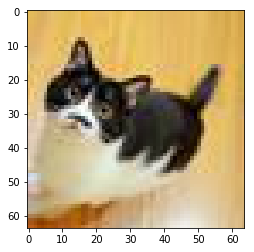

In [5]:
# 图片示例
index = 150
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])] +  "' picture.")

在构造神经网络时，很多bug是由于矩阵/向量的维度不匹配导致的。处理好维度问题能够规避很多错误。

**获取数据集大小，shape 等**

In [6]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 2005
Number of testing examples: m_test = 503
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (2005, 64, 64, 3)
train_set_y shape: (1, 2005)
test_set_x shape: (503, 64, 64, 3)
test_set_y shape: (1, 503)


In [7]:
print(train_set_x_orig.shape[0])

2005


为了方便计算，接下来需要对输入数据进行降维处理。把 shape 为（高，宽，深度）的图片处理成（高\*宽\*深度, 1）。

```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 2005)
train_set_y shape: (1, 2005)
test_set_x_flatten shape: (12288, 503)
test_set_y shape: (1, 503)
sanity check after reshaping: [244 253 255 242 250]


表示图片的每个像素点rgb的值都在 0 到 255 之间。

在机器学习中常用的一种数据处理方法，是数据的中心化和标准化，这意味着你需要对整个数据集除以标准差。但是对于图片数据，最简便的做法是直接除以 255.

In [9]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

<font color='blue'>
**note**:
    * 弄清楚数据的 shape
    * reshape 数据，得到合适的数据结构
    * 标准化数据

## 3 - 构造学习算法图

对于一个样例$x^{(i)}$:

$$z^{(i)} = w^{T}x{(i)} + b$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$
$$L(a^{(i)}, y^{(i)}) = -y^{(i)}log(a^{(i)} - (1 - y^{(i)})log(1 - a^{(i)}))$$

通过对有所的训练集的loss求和，得到cost:
    $$J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)}, y^{(i)})$$
    
**关键步骤**
* 初始化模型的参数
* 梯度下降，使cost最小化
* 使用训练好的模型预测数据
* 分析结果

## 4 - 构造部分算法

构建神经网络的主要步骤如下：
1 定义模型结构（例如输入特征数量）
2 初始化模型参数
3 loop:
    * 计算当前loss（前向传播）
    * 计算当前梯度（反向传播）
    * 更新参数（梯度下降）
    
### 4.1 - 辅助函数

实现**sigmoid**函数

In [10]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

print(sigmoid(np.array([0, 2])))

[ 0.5         0.88079708]


### 4.2 - 初始化参数

使用 np.zeros 函数构造参数 w,b

In [11]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print(w, b)

[[ 0.]
 [ 0.]] 0


对于图片输入，w 的 shape 因该是 (num_px \* numpx \* 3, 1)

### 4.3 - 前向传播，反向传播

实现 `propagate()` 函数，计算 cost function 和 梯度

**前向传播**
* x
* 计算 $A = \sigma(w^TX + b) = (a^{(1)}, a^{(2)}, ... a^{(m)})$
* 计算 cost function $ J = -\frac{1}{m}\sum_{i=1}^{m}(y^{i}log(a^{(i)}) + (1-y^{(i)})log(1-a^{(i)}))$

另外两个需要的公式：
$$\frac{\partial J}{\partial w} = \frac{1}{m}X(A - Y)^T$$
$$\frac{\partial J}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}(a^{(i)} - y^{(i)})$$

In [20]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    m = X.shape[1]
    A = sigmoid(w.T.dot(X) + b)     # 计算 activation
    cost = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) / m                      # compute cost
    
    dw = X.dot((A-Y).T) / m
    db = np.sum(A - Y) / m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [21]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99845601]
 [ 2.39507239]]
db = 0.00145557813678
cost = 5.80154531939


### 4.4 - 优化

是有梯度下降优化算法

$\theta = \theta - \alpha d \theta$

In [14]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        # update
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print("cost after %i iteration: %f" % (i, cost))
    
    params = {
        'w': w,
        'b': b
    }
    
    grads = {
        'dw': dw,
        'db': db
    }
    
    return params, grads, costs


In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 0.19033591]
 [ 0.12259159]]
b = 1.92535983008
dw = [[ 0.67752042]
 [ 1.41625495]]
db = 0.219194504541


上述函数返回了训练好的 w,b 参数，接下来要使用该参数进行预测

* 计算 $\hat{Y} = \sigma(w^TX + b)$
* 把计算结果转化成0(< 0.5)或1(>=0.5)

In [16]:
def predict(w, b, X):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """
    
    m = X.shape[1]
    Y_predict = np.zeros((1, m))
    A = sigmoid(np.dot(w.T, X) + b )
    Y_predict[A >= 0.5] = 1
    Y_predict[A < 0.5] = 0
    
    assert(Y_predict.shape == (1, m))
    
    return Y_predict


In [17]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 1.  1.  0.]]


## 5 - 合并所有的函数到一个 model 中

使用 model 函数 合并以上几个函数调用步骤

In [18]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    # 初始化参数 w, b
    w = np.zeros((X_train.shape[0], 1))
    # w = np.random.random_sample((X_train.shape[0], 1))  # 使用随机初始化
    b = 0
    
    # 梯度下降优化
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params['w']
    b = params['b']
    
    Y_predictions_test = predict(w, b, X_test)
    Y_predictions_train = predict(w, b, X_train)
    
    print('train set ac rate: {} %'.format(100 - np.mean(np.abs(Y_predictions_train - Y_train)) * 100))
    print('test set ac rate: {} %'.format(100 - np.mean(np.abs(Y_predictions_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_predictions_test, 
         "Y_prediction_train" : Y_predictions_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d
    

In [26]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.01, print_cost = True)

cost after 0 iteration: 0.693147
cost after 100 iteration: 1.172041
cost after 200 iteration: 2.227245
cost after 300 iteration: 4.606382
cost after 400 iteration: 0.945747
cost after 500 iteration: 1.850345
cost after 600 iteration: 0.883472
cost after 700 iteration: 0.768859
cost after 800 iteration: 1.776313
cost after 900 iteration: 0.992178
cost after 1000 iteration: 0.940111
cost after 1100 iteration: 1.832893
cost after 1200 iteration: 1.975511
cost after 1300 iteration: 1.036321
cost after 1400 iteration: 0.712715
cost after 1500 iteration: 0.843606
cost after 1600 iteration: 1.499282
cost after 1700 iteration: 0.848421
cost after 1800 iteration: 4.255733
cost after 1900 iteration: 0.857426
train set ac rate: 57.85536159600998 %
test set ac rate: 50.09940357852883 %


y= 1.0


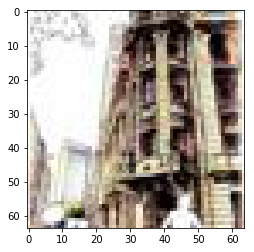

In [23]:
y_prediction_test = d['Y_prediction_test']
index = 110
plt.imshow(test_set_x_orig[index])
print("y=", y_prediction_test[0][index])

打印出训练过程的 cost 曲线

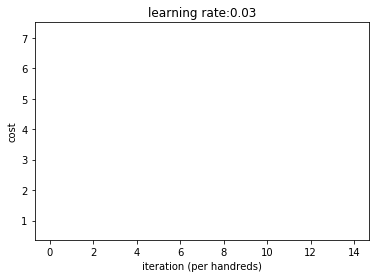

In [24]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iteration (per handreds)')
plt.title('learning rate:' + str(d['learning_rate']))
plt.show()

**learning rate**的选择

learning rate is: 0.005
cost after 0 iteration: 0.693147
cost after 100 iteration: 0.773666
cost after 200 iteration: 0.570001
cost after 300 iteration: 0.721470
cost after 400 iteration: 0.564436
cost after 500 iteration: 1.730967
cost after 600 iteration: 1.159579
cost after 700 iteration: 0.557994
cost after 800 iteration: 0.895563
cost after 900 iteration: 1.786462
cost after 1000 iteration: 0.574079
cost after 1100 iteration: 0.574239
cost after 1200 iteration: 0.581875
cost after 1300 iteration: 0.675478
cost after 1400 iteration: 0.680229
train set ac rate: 76.20947630922693 %
test set ac rate: 81.31212723658052 %

-------------------------------------------------------

learning rate is: 0.0005
cost after 0 iteration: 0.693147
cost after 100 iteration: 0.593661
cost after 200 iteration: 0.580156
cost after 300 iteration: 0.573232
cost after 400 iteration: 0.568594
cost after 500 iteration: 0.565051
cost after 600 iteration: 0.562137
cost after 700 iteration: 0.559626
cost after

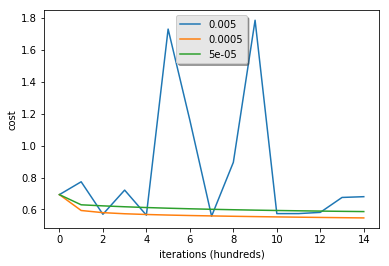

In [27]:
learning_rates = [0.005, 0.0005, 0.00005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = True)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()